In [1]:
import pandas as pd
#import clusterpy
import geopandas as gpd
import numpy as np
from numpy import median
from multiprocessing import Pool
import matplotlib.pyplot as plt
from cycler import cycler
import umap
import numpy as np
import pandas as pd
import requests
import os
import datashader as ds
import datashader.utils as utils
import datashader.transfer_functions as tf
import matplotlib.pyplot as plt
import seaborn as sns
import re

In [2]:
X = pd.read_csv('X_DATA_TRXPSE_BC.csv', sep = ',', header = None)
y = pd.read_csv('Y_DATA_TRXPSE_BC.csv', sep = ',', header = None)
data = pd.merge(X, y, left_index=True, right_index=True)
#data = data[0:2700000]
#data

In [3]:
import unidecode
col = ['0_y', 4, 5, 6]
df = data[col]
df = df[pd.notnull(df[5])]
df = df[pd.notnull(df[6])]
df = df.dropna(subset=['0_y', 5, 6])
for ref in df[5]: 
    #print(ref)
    ref = re.sub('[ñáéíóú]', '', str(ref))
    #ref = unidecode.unidecode(str(ref))
for ref in df[6]: 
    #print(ref)
    ref = re.sub('[ñáéíóú]', '', str(ref))
    #ref = unidecode.unidecode(str(ref))
for ref in df['0_y']: 
    #print(ref)
    ref = re.sub('[ñáéíóú]', '', str(ref))
    #print(ref)
    if 'DEFAULT_LABEL' in str(ref):
        ref = 'DEFAULT LABEL'
    #ref = unidecode.unidecode(str(ref))
    
'''    
def remove_accents(a):
    return unidecode.unidecode(a.decode('utf-8'))

df['0_y'] = df['0_y'].apply(remove_accents)
df[5] = df[5].apply(remove_accents)
df[6] = df[6].apply(remove_accents)'''
#df

"    \ndef remove_accents(a):\n    return unidecode.unidecode(a.decode('utf-8'))\n\ndf['0_y'] = df['0_y'].apply(remove_accents)\ndf[5] = df[5].apply(remove_accents)\ndf[6] = df[6].apply(remove_accents)"

In [4]:
df.columns = ['Product','Amount', 'Reference', 'Source']
df['category_id'] = df['Product'].factorize()[0]
category_id_df = df[['Product', 'category_id']].drop_duplicates().sort_values('category_id')
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['category_id', 'Product']].values)
df

,Product,Amount,Reference,Source,category_id
1,Gobierno,1854818.94,presentación y pago del impuesto predial unifi...,aaasauz null,0
3,Servicios bancarios,626001.19,promotora ideales,juan rodriguez mesa b,1
5,Administración central,15002.69,transaccion para generacion de certificados de...,idc,2
6,Educación,16152.11,pago ordinario fic,alarcon conde,3
7,Administración central,14085.63,transaccion para generacion de certificados de...,idc,2
10,Electricidad,523887.79,empresas publicas de medellin esp,cc,4
16,Administración central,10288.46,transaccion para consulta por indice de propie...,idc,2
17,Electricidad,179084.90,empresas publicas de medellin esp,cc,4
18,Electricidad,207195.05,empresas publicas de medellin esp,cc,4
19,Administración central,9935.88,transaccion para consulta por indice de propie...,idc,2


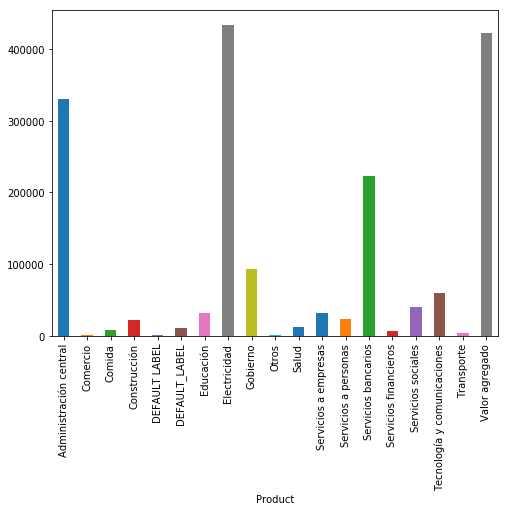

In [5]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(8,6))
df.groupby('Product').Reference.count().plot.bar(ylim=0)
plt.show()


In [6]:
from sklearn.feature_extraction.text import TfidfVectorizer
from stop_words import get_stop_words

#stop_words = get_stop_words('en')
stop_words = get_stop_words('spanish')

#from stop_words import safe_get_stop_words
#stop_words = safe_get_stop_words('unsupported language')

tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words=stop_words)
features = tfidf.fit_transform(df.Reference, df.Source).toarray()
labels = df.category_id
features.shape

(1756312, 8065)

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB

X_train, X_test, y_train, y_test = train_test_split(df[['Amount', 'Reference', 'Source']], df['Product'], random_state = 0)
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
#clf = MultinomialNB().fit(X_train_tfidf, y_train)

In [8]:
print(category_id_df.Product.values)

['Gobierno' 'Servicios bancarios' 'Administraci\xc3\xb3n central'
 'Educaci\xc3\xb3n' 'Electricidad' 'Valor agregado' 'Construcci\xc3\xb3n'
 'Servicios sociales' 'Servicios a empresas' 'Transporte'
 'Tecnolog\xc3\xada y comunicaciones' 'Salud' 'Servicios financieros'
 'Comida' 'Otros' 'Servicios a personas' 'DEFAULT LABEL' 'Comercio'
 'DEFAULT_LABEL']


In [9]:
category_id_df.Product.values[2]='Administracion central'
category_id_df.Product.values[3]='Educacion'
category_id_df.Product.values[10]='Tecnologia y comunicaciones'
category_id_df.Product.values[6]='Construccion'
print(category_id_df.Product.values)

['Gobierno' 'Servicios bancarios' 'Administracion central' 'Educacion'
 'Electricidad' 'Valor agregado' 'Construccion' 'Servicios sociales'
 'Servicios a empresas' 'Transporte' 'Tecnologia y comunicaciones' 'Salud'
 'Servicios financieros' 'Comida' 'Otros' 'Servicios a personas'
 'DEFAULT LABEL' 'Comercio' 'DEFAULT_LABEL']


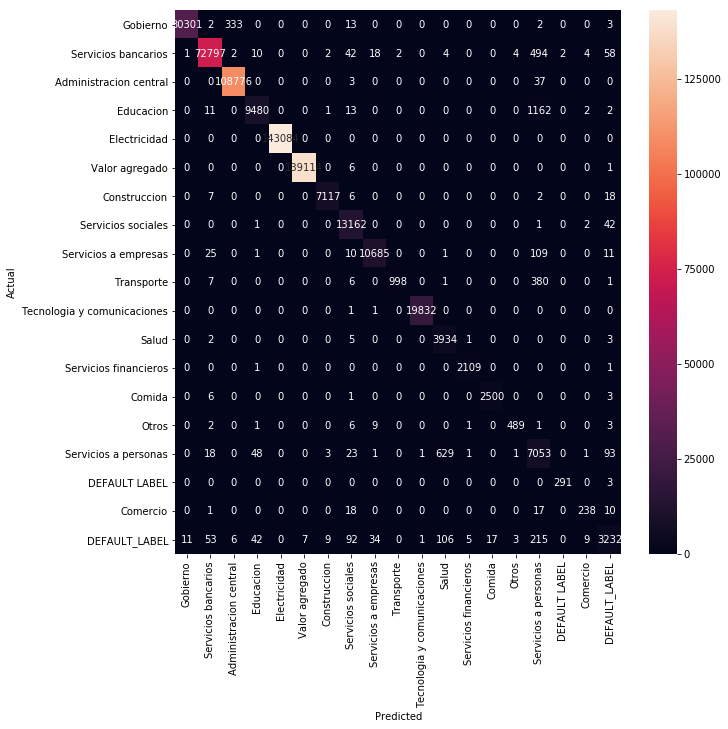

In [10]:
from sklearn.svm import LinearSVC
model = LinearSVC()
X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features, labels, df.index, test_size=0.33, random_state=0)
model.fit(X_train, y_train)
from sklearn.externals import joblib
joblib.dump(model, 'SVC.joblib') 
y_pred = model.predict(X_test)
#print('Accuracy: ' + model.score(y_test, y_pred) )
from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=category_id_df.Product.values, yticklabels=category_id_df.Product.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [11]:
from IPython.display import display
for predicted in category_id_df.category_id:
  for actual in category_id_df.category_id:
    if predicted != actual and conf_mat[actual, predicted] >= 10:
      print("'{}' predicted as '{}' : {} examples.".format(id_to_category[actual], id_to_category[predicted], conf_mat[actual, predicted]))
      display(df.loc[indices_test[(y_test == actual) & (y_pred == predicted)]][['Product', 'Reference']])
      print('')

'DEFAULT_LABEL' predicted as 'Gobierno' : 11 examples.


,Product,Reference
2209490,DEFAULT_LABEL,pago de impuesto ier
886884,DEFAULT_LABEL,pago de impuesto kjk
887143,DEFAULT_LABEL,pago de impuesto jgl
1289013,DEFAULT_LABEL,pago de impuestos para la placa iat
2862088,DEFAULT_LABEL,impuestos tasas contribuciones y/o sspp
1594152,DEFAULT_LABEL,impuesto+de+veh%f%fculos+departamento+de+calda...
2137430,DEFAULT_LABEL,pago de impuesto qhs
826943,DEFAULT_LABEL,pago de impuesto hxp
1562536,DEFAULT_LABEL,pago impuesto municipal
885762,DEFAULT_LABEL,pago de impuestos para la placa fgh



'Educación' predicted as 'Servicios bancarios' : 11 examples.


,Product,Reference
2630152,Educación,juand sanchez abril
2105952,Educación,mayo abril
1335456,Educación,ospina victoria juan jose ()
220220,Educación,ii simposio urgencias médicas (estudiantes)
2590279,Educación,gonzalez hernandez samuel ()
1397529,Educación,gonzalez hernandez samuel ()
3010946,Educación,cortazar garzon juan david()
888607,Educación,diplomado en compra pública: régimen actual y ...
1457407,Educación,zamorano rios laura ()
176169,Educación,matias gil i



'Servicios a empresas' predicted as 'Servicios bancarios' : 25 examples.


,Product,Reference
2219262,Servicios a empresas,marzo
2172218,Servicios a empresas,oc:
430626,Servicios a empresas,septiembre
306583,Servicios a empresas,abril
2909433,Servicios a empresas,agosto
1752372,Servicios a empresas,julio
1884422,Servicios a empresas,enero
543303,Servicios a empresas,marzo
2242434,Servicios a empresas,factura de enero
1023250,Servicios a empresas,oc:



'Servicios a personas' predicted as 'Servicios bancarios' : 18 examples.


,Product,Reference
442152,Servicios a personas,julio
179169,Servicios a personas,andrés gonzález () libre
1833766,Servicios a personas,ana patricia
593840,Servicios a personas,natalia rodriguez
2273878,Servicios a personas,julio
2712318,Servicios a personas,nathaly buitrago gonzalez
2818849,Servicios a personas,cuota de sostenimiento ao
751277,Servicios a personas,pago admin mes de junio
565926,Servicios a personas,este es el excedente para la inscripcin a los ...
710859,Servicios a personas,cuota asociación



'DEFAULT_LABEL' predicted as 'Servicios bancarios' : 53 examples.


,Product,Reference
2136611,DEFAULT_LABEL,cuota administracion con descuento septiembre
2862071,DEFAULT_LABEL,administraci?n agosto
2209113,DEFAULT_LABEL,tranexco sa
3109296,DEFAULT_LABEL,pedido # | silvestre dangong [ preventa ]
2019398,DEFAULT_LABEL,pago mes mayo
1562481,DEFAULT_LABEL,pago restante para el proyecto hotelkarmairi
3108931,DEFAULT_LABEL,agua
2862952,DEFAULT_LABEL,juan esteban montoya marin
886278,DEFAULT_LABEL,pago servicios juristapp
1528180,DEFAULT_LABEL,deposito mes de julio



'Gobierno' predicted as 'Administración central' : 333 examples.


,Product,Reference
2847528,Gobierno,factura por concepto de impuesto predial
1060568,Gobierno,factura por concepto de ejecuciones fiscales
2062083,Gobierno,factura por concepto de impuesto predial
1614683,Gobierno,factura por concepto de generado por taquilla
1511311,Gobierno,factura por concepto de impuesto predial
1178319,Gobierno,factura por concepto de impuesto predial
1132730,Gobierno,factura por concepto de impuesto predial
333616,Gobierno,factura por concepto de impuesto predial
408793,Gobierno,factura por concepto de impuesto predial
2896488,Gobierno,factura por concepto de impuesto predial



'Servicios bancarios' predicted as 'Educación' : 10 examples.


,Product,Reference
2979550,Servicios bancarios,mensualidad mayo
2368178,Servicios bancarios,pensiones noviembre y diciembre
622112,Servicios bancarios,afiliacion luciana repatriacion david
2838573,Servicios bancarios,juan sebastian duque mosquera
2355725,Servicios bancarios,pago de productos a domicilio
174793,Servicios bancarios,restaurante y hotel la cuspide
1381253,Servicios bancarios,andres felipe sanin gaviria
498638,Servicios bancarios,andres felipe sanin
2923282,Servicios bancarios,pago pension
1421971,Servicios bancarios,john esteban cano



'Servicios a personas' predicted as 'Educación' : 48 examples.


,Product,Reference
2728981,Servicios a personas,cobro # diciembre
2133090,Servicios a personas,isabela chacón () libre:
1461248,Servicios a personas,cobro # diciembre
299204,Servicios a personas,cobro # enero
2421843,Servicios a personas,cobro # diciembre
3382,Servicios a personas,nota débito # enero
2150480,Servicios a personas,cobro # enero
1903879,Servicios a personas,pension
842491,Servicios a personas,cobro # diciembre
845190,Servicios a personas,cobro # diciembre



'DEFAULT_LABEL' predicted as 'Educación' : 42 examples.


,Product,Reference
1563177,DEFAULT_LABEL,matricula
1527273,DEFAULT_LABEL,pago inscripciones
1564276,DEFAULT_LABEL,certificados
3109027,DEFAULT_LABEL,certificados
2022105,DEFAULT_LABEL,pension
1527433,DEFAULT_LABEL,pensiones
2617660,DEFAULT_LABEL,pago de liquidaci?n de matricula
827839,DEFAULT_LABEL,solicitud tarjeta parqueadero julian david b...
1527096,DEFAULT_LABEL,otros conceptos
2021554,DEFAULT_LABEL,pension



'Gobierno' predicted as 'Servicios sociales' : 13 examples.


,Product,Reference
2948651,Gobierno,
3323606,Gobierno,
1561576,Gobierno,
1889800,Gobierno,twingo
2241737,Gobierno,
388262,Gobierno,captiva riy
2090758,Gobierno,a?o
1777940,Gobierno,
2463974,Gobierno,
3185388,Gobierno,



'Servicios bancarios' predicted as 'Servicios sociales' : 42 examples.


,Product,Reference
3004111,Servicios bancarios,pme
561163,Servicios bancarios,acido tranex?mico %
2798379,Servicios bancarios,padania
3167541,Servicios bancarios,ppv
1137054,Servicios bancarios,edinson hinestroza barahona
1408538,Servicios bancarios,bodegajesmanejo de la cargafotocopias
1582115,Servicios bancarios,yurany vides rugeles
2286102,Servicios bancarios,alquiler salon
2023638,Servicios bancarios,ecolab
1021804,Servicios bancarios,clinicacalima



'Educación' predicted as 'Servicios sociales' : 13 examples.


,Product,Reference
3242745,Educación,i
2006086,Educación,vi jornadas internacionales de humanidades y e...
1642258,Educación,r
3229512,Educación,t
1380336,Educación,r
2014357,Educación,jdsanchezjunio
1551241,Educación,marti dicie
2559272,Educación,facmarzo
2057056,Educación,seminario actualización en fisioterapia pediát...
3136921,Educación,semovientes



'Servicios a empresas' predicted as 'Servicios sociales' : 10 examples.


,Product,Reference
660605,Servicios a empresas,renovacionproponente
2213096,Servicios a empresas,el parrandón del vallenato del carnaval
2719128,Servicios a empresas,promo pasadia
2007950,Servicios a empresas,alarmas
1644579,Servicios a empresas,cotización no op
1197424,Servicios a empresas,actualizacionproponente
1995684,Servicios a empresas,mutacionactividad
213110,Servicios a empresas,edicto
2936840,Servicios a empresas,alarmas
2725064,Servicios a empresas,reinstalacion de teoria cotizacion bd



'Servicios a personas' predicted as 'Servicios sociales' : 23 examples.


,Product,Reference
1216082,Servicios a personas,p
226899,Servicios a personas,p
2333228,Servicios a personas,p
977072,Servicios a personas,precio para residentes
2689995,Servicios a personas,rolandogarcia
851682,Servicios a personas,andrés gonzález () almue
2493065,Servicios a personas,p
1538420,Servicios a personas,p
335587,Servicios a personas,precio para residentes de anestesiologa
2964403,Servicios a personas,speed networking



'Comercio' predicted as 'Servicios sociales' : 18 examples.


,Product,Reference
2782896,Comercio,parlante bluetooth lg npw w und $
3042566,Comercio,ndclhibdo
1442366,Comercio,otrzl
2976846,Comercio,se
1297671,Comercio,buff the original multifuntional headwear adu...
1366255,Comercio,recolección residuos peligrosos
797576,Comercio,minicomponente sony shake x und $
79584,Comercio,fvrw
449503,Comercio,facturataller
2145848,Comercio,sacabstract planet talle alto



'DEFAULT_LABEL' predicted as 'Servicios sociales' : 92 examples.


,Product,Reference
1288153,DEFAULT_LABEL,clo
2209554,DEFAULT_LABEL,lxpqti
827096,DEFAULT_LABEL,soatlbpd
885925,DEFAULT_LABEL,zkthns
3109656,DEFAULT_LABEL,guitbn
2018272,DEFAULT_LABEL,preinscripción a exámenes
2617649,DEFAULT_LABEL,descripcion
1530002,DEFAULT_LABEL,//
885931,DEFAULT_LABEL,riot points
1529725,DEFAULT_LABEL,quiero estudiar pacífico



'Servicios bancarios' predicted as 'Servicios a empresas' : 18 examples.


,Product,Reference
2304376,Servicios bancarios,mayo
243410,Servicios bancarios,octubre de
1276239,Servicios bancarios,mayo
1453084,Servicios bancarios,febrero
3022869,Servicios bancarios,excedente enero febrero marzo y abril
673865,Servicios bancarios,mensualidad junio
973344,Servicios bancarios,pago d?as recogido extras enero y de febrero
1805569,Servicios bancarios,mensualidad febrero
1002040,Servicios bancarios,mensualidad octubre
1558843,Servicios bancarios,mayo de



'DEFAULT_LABEL' predicted as 'Servicios a empresas' : 34 examples.


,Product,Reference
1562016,DEFAULT_LABEL,certificadosvirtuales
887459,DEFAULT_LABEL,mensualidad
2018800,DEFAULT_LABEL,certificadosvirtuales
827127,DEFAULT_LABEL,pago de la reserva
2138038,DEFAULT_LABEL,marzo mensualidad
1563471,DEFAULT_LABEL,pago de la reserva
1562213,DEFAULT_LABEL,renovacionmatricula
3109127,DEFAULT_LABEL,pago de la reserva
2137538,DEFAULT_LABEL,certificadosvirtuales
2863567,DEFAULT_LABEL,servicio tecnico



'Servicios a personas' predicted as 'Salud' : 629 examples.


,Product,Reference
1870942,Servicios a personas,cartera
1265371,Servicios a personas,cartera
1226647,Servicios a personas,cartera
3020411,Servicios a personas,cartera
1063609,Servicios a personas,cartera
709164,Servicios a personas,cartera
426696,Servicios a personas,cartera
1764951,Servicios a personas,cartera
868387,Servicios a personas,cartera
574526,Servicios a personas,cartera



'DEFAULT_LABEL' predicted as 'Salud' : 106 examples.


,Product,Reference
2208956,DEFAULT_LABEL,cartera
2138053,DEFAULT_LABEL,cartera
1530045,DEFAULT_LABEL,cartera
2209953,DEFAULT_LABEL,cartera
2138090,DEFAULT_LABEL,cartera
2138550,DEFAULT_LABEL,desfile de silleteros // medellin ago :am ...
1564569,DEFAULT_LABEL,cartera
1527183,DEFAULT_LABEL,cartera
2468864,DEFAULT_LABEL,cartera
827269,DEFAULT_LABEL,cartera



'DEFAULT_LABEL' predicted as 'Comida' : 17 examples.


,Product,Reference
1564621,DEFAULT_LABEL,pago mapfre seguros colombia
1527662,DEFAULT_LABEL,seguros axa colpatria
1527672,DEFAULT_LABEL,pago mapfre seguros colombia
2022652,DEFAULT_LABEL,pago mapfre seguros colombia
1441038,DEFAULT_LABEL,pago mapfre seguros colombia
3109976,DEFAULT_LABEL,compra a capitalizadora colpatria portal pago...
2019397,DEFAULT_LABEL,pago seguros de vida
1562534,DEFAULT_LABEL,pago seguros de vida
3108562,DEFAULT_LABEL,pago mapfre seguros colombia
2209860,DEFAULT_LABEL,pago seguros de vida



'Servicios bancarios' predicted as 'Servicios a personas' : 494 examples.


,Product,Reference
1840463,Servicios bancarios,pagos
1906946,Servicios bancarios,pagos
1559992,Servicios bancarios,oficina
643936,Servicios bancarios,pagos
276642,Servicios bancarios,pagos
1329786,Servicios bancarios,pagos
2623317,Servicios bancarios,pagos
2453267,Servicios bancarios,pagos
177424,Servicios bancarios,pagos
358621,Servicios bancarios,pagos



'Administración central' predicted as 'Servicios a personas' : 37 examples.


,Product,Reference
144069,Administración central,pagos
1192343,Administración central,pagos
3228162,Administración central,pagos
1044183,Administración central,pagos
2334185,Administración central,pagos
2092489,Administración central,pagos
3000315,Administración central,pagos
2275770,Administración central,pagos
3249877,Administración central,pagos
3317454,Administración central,pagos



'Educación' predicted as 'Servicios a personas' : 1162 examples.


,Product,Reference
157275,Educación,cobro # septiembre
2446958,Educación,pago de los documentos:
2204006,Educación,cobro # febrero
1148652,Educación,pago de los documentos:
1829613,Educación,pago de los documentos:
3223735,Educación,cobro # septiembre
378935,Educación,pago de los documentos:
1664281,Educación,pago de los documentos:
1969982,Educación,pago de los documentos:
1662519,Educación,pago de los documentos:



'Servicios a empresas' predicted as 'Servicios a personas' : 109 examples.


,Product,Reference
1797279,Servicios a empresas,canon de arrendamiento
1125144,Servicios a empresas,canon de arrendamiento
175389,Servicios a empresas,canon de arrendamiento
266156,Servicios a empresas,canon de arrendamiento
1982330,Servicios a empresas,canon de arrendamiento
1100409,Servicios a empresas,canon de arrendamiento
866973,Servicios a empresas,canon de arrendamiento
386420,Servicios a empresas,canon de arrendamiento
2440845,Servicios a empresas,canon de arrendamiento
1896174,Servicios a empresas,canon de arrendamiento



'Transporte' predicted as 'Servicios a personas' : 380 examples.


,Product,Reference
1339018,Transporte,pagos
2391110,Transporte,pagos
3112761,Transporte,pagos
482892,Transporte,pagos
3074605,Transporte,pagos
3039939,Transporte,pagos
1113933,Transporte,pagos
3047323,Transporte,pagos
2333704,Transporte,pagos
3073170,Transporte,pagos



'Comercio' predicted as 'Servicios a personas' : 17 examples.


,Product,Reference
3317930,Comercio,pago orden #
1265509,Comercio,pago orden #
1316541,Comercio,pago orden #
587563,Comercio,pago
1292736,Comercio,pago orden #
2526639,Comercio,pago orden #
1932308,Comercio,pago orden #
409597,Comercio,pago orden #
29846,Comercio,pago orden #
180676,Comercio,pago orden #



'DEFAULT_LABEL' predicted as 'Servicios a personas' : 215 examples.


,Product,Reference
2468844,DEFAULT_LABEL,pagos
2022021,DEFAULT_LABEL,cobro # febrero
1288829,DEFAULT_LABEL,pagos
1527380,DEFAULT_LABEL,pagos
1564678,DEFAULT_LABEL,pago servicio de internet
1933499,DEFAULT_LABEL,pagos
3109988,DEFAULT_LABEL,pagos
1563162,DEFAULT_LABEL,pagos
3110026,DEFAULT_LABEL,pagos
1440414,DEFAULT_LABEL,pagos



'Servicios bancarios' predicted as 'DEFAULT_LABEL' : 58 examples.


,Product,Reference
732131,Servicios bancarios,pago mensualidad octubre
1276020,Servicios bancarios,cancelaci?n factura
1950622,Servicios bancarios,fc ll corexploit
2816347,Servicios bancarios,administraci?n septiembre cuenta de cobro
3209557,Servicios bancarios,factura
3162340,Servicios bancarios,factura
57155,Servicios bancarios,servicios educativos noviembre
1320254,Servicios bancarios,servicios educativos noviembre
925970,Servicios bancarios,preteens preteens friday : : pm
178223,Servicios bancarios,factura



'Construcción' predicted as 'DEFAULT_LABEL' : 18 examples.


,Product,Reference
3013183,Construcción,factura
359352,Construcción,factura
1480141,Construcción,factura
2139306,Construcción,factura
3106187,Construcción,factura
928562,Construcción,factura
3073946,Construcción,factura
2130261,Construcción,mes de diciembre aptoe parqueadero cuarto util
2615072,Construcción,factura
1643626,Construcción,factura



'Servicios sociales' predicted as 'DEFAULT_LABEL' : 42 examples.


,Product,Reference
3111639,Servicios sociales,pago facturas:
406728,Servicios sociales,pago facturas:
2625499,Servicios sociales,pago facturas:
252087,Servicios sociales,pago facturas:
752609,Servicios sociales,pago facturas:
1077658,Servicios sociales,pago facturas:
2903775,Servicios sociales,pago facturas:
996740,Servicios sociales,pago facturas:
544373,Servicios sociales,pago facturas:
2439081,Servicios sociales,pago facturas:



'Servicios a empresas' predicted as 'DEFAULT_LABEL' : 11 examples.


,Product,Reference
2979976,Servicios a empresas,factura scfv
2203530,Servicios a empresas,pago de facturas: ei
2449757,Servicios a empresas,factura
1571797,Servicios a empresas,factura
129909,Servicios a empresas,pago factura
1793742,Servicios a empresas,pago totalidad contrato
1635386,Servicios a empresas,pago portal citas medicas
2693920,Servicios a empresas,pago factura
1486730,Servicios a empresas,compra: t gimnasioclase grupal a
1779790,Servicios a empresas,legalización anticipo



'Servicios a personas' predicted as 'DEFAULT_LABEL' : 93 examples.


,Product,Reference
1251136,Servicios a personas,pago electrónico: aficionados nivel roger al...
2537939,Servicios a personas,pago factura
2702347,Servicios a personas,comprobante de pago pedido no
1725922,Servicios a personas,pago factura
2457621,Servicios a personas,contrato de arrendamiento
3054320,Servicios a personas,pago factura
2618495,Servicios a personas,pago factura
1888060,Servicios a personas,pago factura
1752912,Servicios a personas,pago factura
2978857,Servicios a personas,pago factura



'Comercio' predicted as 'DEFAULT_LABEL' : 10 examples.


,Product,Reference
2787449,Comercio,compra
505968,Comercio,pago factura
156608,Comercio,pago pedido
2141974,Comercio,comprobante de pago pedido no
1918038,Comercio,comprobante de pago pedido no
1671585,Comercio,factura
303140,Comercio,pago facturas
2114878,Comercio,anticipo
2093101,Comercio,pago facturas
1829733,Comercio,factura


In [12]:
model.fit(features, labels)
N = 2
for Product, category_id in sorted(category_to_id.items()):
  indices = np.argsort(model.coef_[category_id])
  feature_names = np.array(tfidf.get_feature_names())[indices]
  unigrams = [v for v in reversed(feature_names) if len(v.split(' ')) == 1][:N]
  bigrams = [v for v in reversed(feature_names) if len(v.split(' ')) == 2][:N]
  print("# '{}':".format(Product))
  print((unigrams))
  print((bigrams))
  #print((trigrams))
  #print("  . Top unigrams:\n       . {}".format('\n       . '.join(unigrams)))
  #print("  . Top bigrams:\n       . {}".format('\n       . '.join(bigrams)))


# 'Administración central':
[u'aportes', u'permiso']
[u'factura concepto', u'cuota acuerdo']
# 'Comercio':
[u'vinos', u'pet']
[u'venta productos', u'servicios publicos']
# 'Comida':
[u'api', u'actuall']
[u'seguros vida', u'generales colpatria']
# 'Construcción':
[u'oriente', u'anticipos']
[u'pago cartera', u'cuota inicial']
# 'DEFAULT LABEL':
[u'comedor', u'refrigerio']
[u'pse terpel', u'terpel numero']
# 'DEFAULT_LABEL':
[u'od', u'recaudo']
[u'salud vida', u'cuota prestamo']
# 'Educación':
[u'restaurante', u'ruta']
[u'cuota varios', u'colegio calasanz']
# 'Electricidad':
[u'publicas', u'esp']
[u'publicas medellin', u'empresas publicas']
# 'Gobierno':
[u'presentaci\xe3\xb3n', u'impuesto']
[u'presentaci\xe3\xb3n pago', u'pago predial']
# 'Otros':
[u'santillana', u'tkt']
[u'pago vuelos', u'pagos medellin']
# 'Salud':
[u'may', u'abr']
[u'curso soporte', u'soporte vital']
# 'Servicios a empresas':
[u'monitoreo', u'cubo']
[u'recarga saldo', u'derechos renovacion']
# 'Servicios a personas':


In [13]:
print('Accuracy: ' + str(model.score(X_test, y_test)))

Accuracy: 0.9927689390475566


In [14]:
from sklearn import metrics
print(metrics.classification_report(y_test, y_pred, target_names=category_id_df.Product.values))
#print(df['Product'].unique())



                             precision    recall  f1-score   support

                   Gobierno       1.00      0.99      0.99     30654
        Servicios bancarios       1.00      0.99      0.99     73440
     Administracion central       1.00      1.00      1.00    108816
                  Educacion       0.99      0.89      0.94     10671
               Electricidad       1.00      1.00      1.00    143084
             Valor agregado       1.00      1.00      1.00    139121
               Construccion       1.00      1.00      1.00      7150
         Servicios sociales       0.98      1.00      0.99     13208
       Servicios a empresas       0.99      0.99      0.99     10842
                 Transporte       1.00      0.72      0.83      1393
Tecnologia y comunicaciones       1.00      1.00      1.00     19834
                      Salud       0.84      1.00      0.91      3945
      Servicios financieros       1.00      1.00      1.00      2111
                     Comida      

                             precision    recall  f1-score   support

                   Gobierno       1.00      0.99      0.99     30654
        Servicios bancarios       1.00      0.99      0.99     73440
     Administracion central       1.00      1.00      1.00    108816
                  Educacion       0.99      0.89      0.94     10671
               Electricidad       1.00      1.00      1.00    143084
             Valor agregado       1.00      1.00      1.00    139121
               Construccion       1.00      1.00      1.00      7150
         Servicios sociales       0.98      1.00      0.99     13208
       Servicios a empresas       0.99      0.99      0.99     10842
                 Transporte       1.00      0.72      0.83      1393
Tecnologia y comunicaciones       1.00      1.00      1.00     19834
                      Salud       0.84      1.00      0.91      3945
      Servicios financieros       1.00      1.00      1.00      2111
                     Comida      